# Python Configuration

In [1]:
# python version:
from platform import python_version
print(f"python version = {python_version()}")

# We used the following version:
# python version = 3.8.6

python version = 3.8.6


In [2]:
# python standard library packages:
import importlib

# import more packages:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# import own package:
import functions as my

# the following package is only needed to view data interactively,
# otherwise you can comment the import out:
import qgrid  # https://github.com/quantopian/qgrid

In [3]:
# package versions:
print(f"numpy      version = {np.__version__}")
print(f"pandas     version = {pd.__version__}")
print(f"matplotlib version = {matplotlib.__version__}")

# the following package is only needed to view data interactively,
# otherwise you can comment this out:
print(f"qgrid      version = {qgrid.__version__}")

# We used the following versions:
# numpy      version = 1.19.2
# pandas     version = 1.1.3
# matplotlib version = 3.3.2
# qgrid      version = 1.3.1

numpy      version = 1.19.2
pandas     version = 1.1.3
matplotlib version = 3.3.2
qgrid      version = 1.3.1


# Raw Data Source

- **Source:** [data.open-power-system-data.org](https://data.open-power-system-data.org/time_series/): *This package version only contains data provided by TSOs and power exchanges via ENTSO-E Transparency, covering the period 2015-mid 2020.*
- **Download** `time_series_15min_singleindex.csv` **after filtering to**

    + time window: 2016
    + region: DE
    + columns: solar_generation_actual, wind_generation_actual
    
    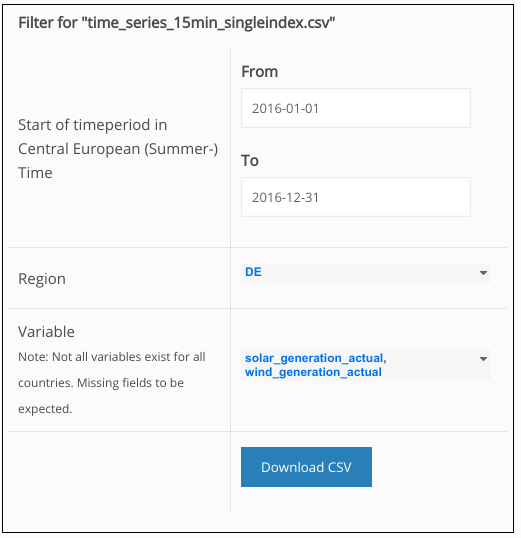
    
- time frame: 2016
- sampling interval: 15 minutes
- location: DE
- unit: MW
- **legal notice:** *Attribution in Chicago author-date style should be given as follows: "Open Power System Data. 2020. Data Package Time series. Version 2020-10-06. https://doi.org/10.25832/time_series/2020-10-06. (Primary data from various sources, for a complete list see URL)."*

# Loading Raw Data

In [4]:
my_path = "../data/rg/raw/"
my_file = "time_series_15min_singleindex_filtered.csv"

In [5]:
if 1:   # read raw data from csv: THIS TAKES QUITE LONG!
    print(f"reading raw data (be patient!) ... ", end="")
    # 2014-12-11T17:45:00Z,2014-12-11T18:45:00+0100
    # https://docs.python.org/3/library/datetime.html#strftime-and-strptime-format-codes
    my_parser = lambda date: pd.to_datetime(date, format='%Y-%m-%dT%H:%M:%S%z').tz_localize(None)
    
    my_df = pd.read_csv(my_path + my_file,
                        # nrows=10000,         # later None or commented
                        usecols=['cet_cest_timestamp',
                                 'DE_solar_generation_actual',
                                 'DE_wind_generation_actual'],
                        parse_dates=['cet_cest_timestamp'], # makes these columns to type Timestamp
                        date_parser=my_parser,
                        index_col='cet_cest_timestamp'
                       )
    # for i, item in enumerate(df.columns):
    #     print(f"{i}: {item}")
    my_df.index.name = 'time'
    # export raw data to pickle:
    my_df.to_pickle('../data/rg/processed/rg_df_all.pickle')  # maybe set protocol=4 later
    print("finished.")
else:    # import pickle to be faster:
    my_df = pd.read_pickle('../data/rg/processed/rg_df_all.pickle')

reading raw data (be patient!) ... finished.


## First View on Raw Data

In [6]:
my_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35136 entries, 2016-01-01 00:00:00 to 2016-12-31 23:45:00
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   DE_solar_generation_actual  34848 non-null  float64
 1   DE_wind_generation_actual   34838 non-null  float64
dtypes: float64(2)
memory usage: 823.5 KB


In [7]:
my_df.head(3)

,DE_solar_generation_actual,DE_wind_generation_actual
time,,
2016-01-01 00:00:00,0.0,8878.35
2016-01-01 00:15:00,0.0,8687.59
2016-01-01 00:30:00,0.0,8553.69


In [8]:
my_df.tail(3)

,DE_solar_generation_actual,DE_wind_generation_actual
time,,
2016-12-31 23:15:00,0.0,14997.73
2016-12-31 23:30:00,0.0,15074.59
2016-12-31 23:45:00,0.0,15236.40


# Processing of Raw Data

## Fill NaN-Values

In [9]:
my_number_NaN = my_df[my_df.isna().any(axis=1)].shape[0]
print(f"Found {my_number_NaN} rows with a NaN value.")

Found 298 rows with a NaN value.


In [10]:
# missing days/times:
my_day = '2016-03-27'  # 02:00 - 02:45 missing -> time change
my_day = '2016-05-31'  # 23:00 - 23:45 missing
my_day = '2016-06-01'  # almost all day missing
my_day = '2016-10-28'  # all day missing
my_day = '2016-11-03'  # 14:45 - 17:00 missing wind generation
my_day = '2016-12-09'  # all day missing

# qgrid.show_grid(my_df.loc[my_day,]) 

In [11]:
# '2016-03-27': 02:00 - 02:45 => linear interpolation
my_range = pd.date_range(start='2016-03-27 02:00:00',
                         end  ='2016-03-27 02:45:00', freq='15min')
my_values = [(1 - k/5)*20955.95 + k/5*21063.06 for k in range(1,5)]

my_df_fill = pd.DataFrame(index=my_range,
                          data= {'DE_solar_generation_actual':[0]*4,
                                 'DE_wind_generation_actual' :my_values})
my_df = my_df.append(my_df_fill).sort_index()

In [12]:
# '2016-03-27': 02:00 - 02:45 => prolong with mean of hour before
my_range = pd.date_range(start='2016-05-31 23:00:00',
                         end  ='2016-05-31 23:45:00', freq='15min')
my_values = [ np.mean([4406.55, 4356.8, 4376.87, 4513.47]) ]*4

my_df_fill = pd.DataFrame(index=my_range,
                          data= {'DE_solar_generation_actual':[0]*4,
                                 'DE_wind_generation_actual' :my_values})

my_df.drop(my_range, inplace=True)
my_df = my_df.append(my_df_fill).sort_index()

In [13]:
# '2015-06-01': fill with mean of neighouring days:
my_df.drop(my_df.loc['2016-06-01',].index, inplace=True)

my_range = pd.date_range(start='2016-06-01 00:00:00',
                         end  ='2016-06-01 23:45:00', freq='15min')

my_df_fill = pd.DataFrame(index=my_range, columns=my_df.columns,
                          data=(my_df.loc['2016-05-31',].values + 
                                my_df.loc['2016-06-02',].values)/2)
    
my_df = my_df.append(my_df_fill).sort_index()

In [14]:
# my_day = '2016-10-28: fill with mean of neighouring days:
my_df.drop(my_df.loc['2016-10-28',].index, inplace=True)

my_range = pd.date_range(start='2016-10-28 00:00:00',
                         end  ='2016-10-28 23:45:00', freq='15min')
my_df_fill = pd.DataFrame(index=my_range, columns=my_df.columns,
                          data=(my_df.loc['2016-10-27',].values + 
                                my_df.loc['2016-10-29',].values)/2)
    
my_df = my_df.append(my_df_fill).sort_index()

In [15]:
# my_day = '2016-11-03' 14:45 - 17:00 => linear interpolation
my_range = pd.date_range(start='2016-11-03 14:45:00',
                         end  ='2016-11-03 17:00:00', freq='15min')
my_values = [(1 - k/11)*2459.71 + k/11*3236.69 for k in range(1,11)]

my_df.loc[my_range,'DE_wind_generation_actual'] = my_values

In [16]:
# my_day = '2016-12-09' fill with mean of neighouring days:
my_df.drop(my_df.loc['2016-12-09',].index, inplace=True)

my_range = pd.date_range(start='2016-12-09 00:00:00',
                         end  ='2016-12-09 23:45:00', freq='15min')

my_df_fill = pd.DataFrame(index=my_range, columns=my_df.columns,
                          data=(my_df.loc['2016-12-08',].values + 
                                my_df.loc['2016-12-10',].values)/2)
    
my_df = my_df.append(my_df_fill).sort_index()

In [17]:
my_number_NaN = my_df.loc['2016'][my_df.loc['2016'].isna().any(axis=1)].shape[0]
print(f"Found {my_number_NaN} rows with a NaN value.")

Found 0 rows with a NaN value.


## Checks

In [18]:
# importlib.reload(my);
my.checks(my_df, my_year='2016')

- check for rows with a NaN value: OK
                     DE_solar_generation_actual  DE_wind_generation_actual
2016-10-30 02:00:00                         0.0                   8096.620
2016-10-30 02:15:00                         0.0                   8255.210
2016-10-30 02:30:00                         0.0                   8000.860
2016-10-30 02:45:00                         0.0                   8053.885


In [19]:
# qgrid.show_grid(my_df.loc['2016-10-30'])

In [20]:
# qgrid.show_grid(my_df.groupby(my_df.index).mean().loc['2016-10-30'])

In [21]:
# mean out duplicate timestamps:
my_df = my_df.groupby(my_df.index).mean()

In [22]:
my.checks(my_df, my_year='2016')

- check for rows with a NaN value: OK
- check for duplicate timestamps : OK
- check for set of timestamps    : OK


In [23]:
# check time changes in 2016 by visual inspection:
# qgrid.show_grid(my_df.loc['2016-03-27'])
# qgrid.show_grid(my_df.loc['2016-10-30'])

## Create Renewable Generation

In [24]:
my_df['RG_MW'] = my_df['DE_solar_generation_actual'] + \
                 my_df['DE_wind_generation_actual']

# drop unneeded columns:
my_df.drop(['DE_solar_generation_actual', 
            'DE_wind_generation_actual'], axis=1, inplace=True)

In [25]:
my_df.head(3)

,RG_MW
2016-01-01 00:00:00,8878.35
2016-01-01 00:15:00,8687.59
2016-01-01 00:30:00,8553.69


# Export of Renewable Generation

In [26]:
# export data to pickle:
my_df.to_pickle('../data/rg/processed/rg_df.pickle')

if 0: # export data to csv:
    my_df.to_pickle('../data/rg/processed/rg_df.csv')

# Plot RG Data

In [27]:
# load the processed data from pickle file:
my_df = pd.read_pickle('../data/rg/processed/rg_df.pickle')

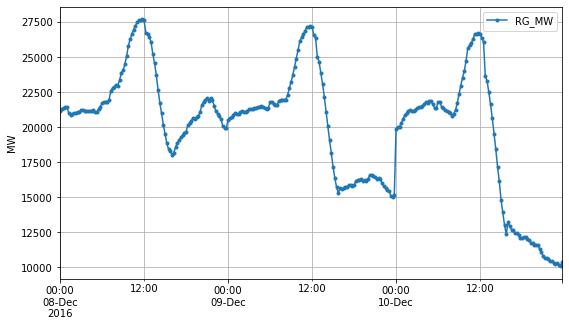

In [28]:
# my_df['2016-05-30':'2016-06-04'].plot(figsize=(9,5),marker='.')
# my_df['2016-10-26':'2016-10-30'].plot(figsize=(9,5),marker='.')
# my_df['2016-11-03'].plot(figsize=(9,5),marker='.')
my_df['2016-12-08':'2016-12-10'].plot(figsize=(9,5),marker='.')

plt.grid(True, which='both')
plt.ylabel('MW');